# Table of Contents

1. [Data Analysis](#Data-Analysis)
2. [Sentiment Classification](#Sentiment-Classification)
3. [Reviews Clustering](#Reviews-Clustering)
4. [Recommendation System](#Recommendation-System)
5. [Rating Prediction with PyTorch](#Rating-Prediction-with-PyTorch)
6. [Word Embedding NLP](#Word-Embedding-NLP)

# Data Parsing and DataFrame Creation

We open a text file containing cell phone data, extract key-value pairs, and store them in a list. Then, we convert the list into a pandas DataFrame for easier analysis.


In [35]:
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt


with open("Cell_Phones_&_Accessories.txt", 'r', encoding='utf-8') as file:
    all_data = []
    current_item = defaultdict(str) 

    for line in file:
        line = line.strip()

        if not line: 
            if current_item:
                all_data.append(dict(current_item))
                current_item.clear()
            continue

        if ":" in line:
            key, value = map(str.strip, line.split(":", 1))
            current_item[key] = value

    if current_item:
        all_data.append(dict(current_item))

df = pd.DataFrame(all_data)

#### Data Cleaning and Transformation

We rename columns to make them more user-friendly, convert the review timestamp into a readable date format, and ensure ratings are numeric. We also split the helpfulness data into two separate columns (helpful votes and total votes), drop the original helpfulness column, and save the cleaned data into a CSV file for further use.


In [36]:
better_column_names = {
    'product/productId': 'product_id',
    'product/title': 'product_name',
    'product/price': 'price',
    'review/userId': 'user_id',
    'review/profileName': 'username',
    'review/helpfulness': 'helpfulness',
    'review/score': 'rating',
    'review/time': 'review_date',
    'review/summary': 'review_summary',
    'review/text': 'review_text'
}

df = df.rename(columns=better_column_names)

df['review_date'] = pd.to_datetime(df['review_date'], unit='s')

df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

df[['helpful_votes', 'total_votes']] = df['helpfulness'].str.split('/', expand=True).astype(int)

df = df.drop('helpfulness', axis=1)

df.to_csv('amazon_reviews.csv', index=False)

print(df.head())
print(df.dtypes)

/var/folders/69/3bgwy7vx3g9g3hc8fwyj9pfh0000gn/T/ipykernel_95589/1216614534.py:16: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['review_date'] = pd.to_datetime(df['review_date'], unit='s')


   product_id                                       product_name    price  \
0  B000JVER7W  Mobile Action MA730 Handset Manager - Bluetoot...  unknown   
1  B000JVER7W  Mobile Action MA730 Handset Manager - Bluetoot...  unknown   
2  B000JVER7W  Mobile Action MA730 Handset Manager - Bluetoot...  unknown   
3  B000924R5I  USB Data Cable for Sony-Ericsson Z600, Z500, Z...  unknown   
4  B000924R5I  USB Data Cable for Sony-Ericsson Z600, Z500, Z...  unknown   

          user_id                            username  rating review_date  \
0  A1RXYH9ROBAKEZ                             A. Igoe     1.0  2009-01-31   
1   A7L6E1KSJTAJ6                        Steven Martz     5.0  2007-10-04   
2  A2NOQQ7I6PU7CW  Daniel M. Johnson "rocknbluesharp"     4.0  2007-08-10   
3  A29Q0CLOF0U8BN                            E. Owens     4.0  2006-04-28   
4   ANNHJND2MHUI3         Isaac Salas "=CRBF=gB^link"     1.0  2007-03-12   

                                      review_summary  \
0                 

# Data Analysis


#### Product Analysis


Number of unique products: 7438

Summary of Number of Reviews Per Product:
count    7438.000000
mean       10.611724
std        53.478478
min         1.000000
25%         1.000000
50%         2.000000
75%         6.000000
max      3443.000000
Name: count, dtype: float64

Number of products with at least 20 reviews: 741


/var/folders/69/3bgwy7vx3g9g3hc8fwyj9pfh0000gn/T/ipykernel_95589/2065399025.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_reviewed_product_counts.values, y=top_reviewed_products.values, palette="viridis")


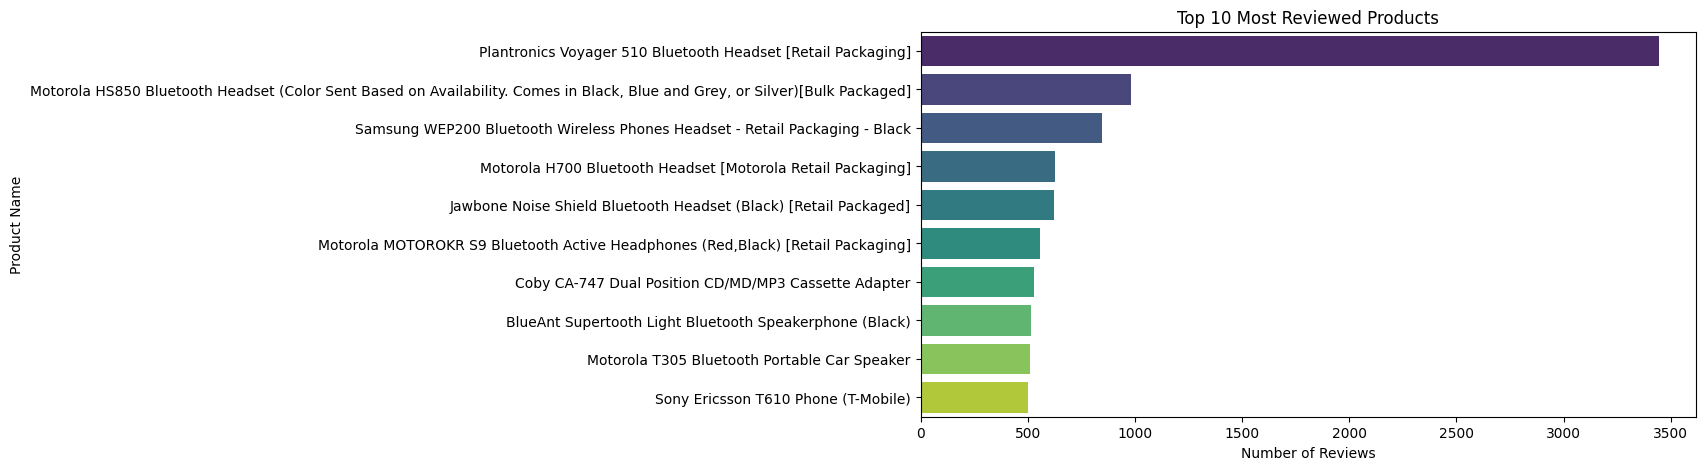


 Top 10 Highest Rated Products (Min. 20 Reviews):
Nokia CA-53 Connectivity Cable: 4.80
MOTOROLA OEM SNN5683A BATTERY FOR i90 i95 i60 v545: 4.78
Standard Lithium-Ion Battery (850mAh) for Sanyo SCP-3100, SCP-2400, 3100, 2400, 8400, 7000: 4.71
Plantronics USB Adaptor Explorer 320 Voyager: 4.70
Nokia OEM CA-53 USB data cable for Nokia 3300 6230 6255i 6620 6651 7610 3155i 6235i 6282 6265i 6126 9300 9500 & more: 4.62
Motorola Right Angle Charger Adapter Mini-USB - SKN6182: 4.62
Multi-Use Vehicle Charger with Dual USB Ports and Dual 12 Volt Sockets - Magnadyne: 4.61
Plantronics CS50 Battery: 4.58
PalmOne m100 series Faceplate Cover (Silver Mist): 4.56
PalmOne m100 series Faceplate Cover (Blue Mist): 4.56


In [37]:
import seaborn as sns

# Print the number of unique products
print(f"Number of unique products: {df['product_id'].nunique()}")

# Describe the number of reviews per product
reviews_per_product = df['product_id'].value_counts()
print("\nSummary of Number of Reviews Per Product:")
print(reviews_per_product.describe())



# Products with at least 20 reviews
products_with_20_reviews = reviews_per_product[reviews_per_product >= 20]
print(f"\nNumber of products with at least 20 reviews: {len(products_with_20_reviews)}")

# Top 10 most reviewed products (by product name instead of ID)
top_reviewed_products = df.groupby('product_id')['product_name'].first().loc[reviews_per_product.head(10).index]
top_reviewed_product_counts = reviews_per_product.head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_reviewed_product_counts.values, y=top_reviewed_products.values, palette="viridis")
plt.xlabel("Number of Reviews")
plt.ylabel("Product Name")
plt.title("Top 10 Most Reviewed Products")
plt.show()


# Top 10 highest rated products with at least 20 reviews
top_rated_products = df.groupby('product_id').filter(lambda x: len(x) >= 20)
top_rated_products_avg_rating = top_rated_products.groupby('product_id')['rating'].mean().sort_values(ascending=False).head(10)

# Get product names for the top rated products
top_rated_product_names = df.groupby('product_id').first()['product_name'].loc[top_rated_products_avg_rating.index]

print("\n Top 10 Highest Rated Products (Min. 20 Reviews):")
for product_name, avg_rating in zip(top_rated_product_names, top_rated_products_avg_rating):
    print(f"{product_name}: {avg_rating:.2f}")


#### User Analysis

Number of 'unknown' users: 2276

Summary of Reviews Per User:
count    68040.000000
mean         1.126602
std          0.626242
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         44.000000
Name: count, dtype: float64

Number of users with at least 5 reviews: 251

Top 10 Most Active Reviewers:
username
John                             47
Chris                            47
Mike                             45
Dave                             45
Gadgester "No Time, No Money"    44
Brendon Edwards                  44
Widget                           38
str222@gmail.com                 36
David                            36
Mark                             34
Name: count, dtype: int64


/var/folders/69/3bgwy7vx3g9g3hc8fwyj9pfh0000gn/T/ipykernel_95589/3020536116.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_reviewers.values, y=top_reviewers.index, palette="coolwarm")


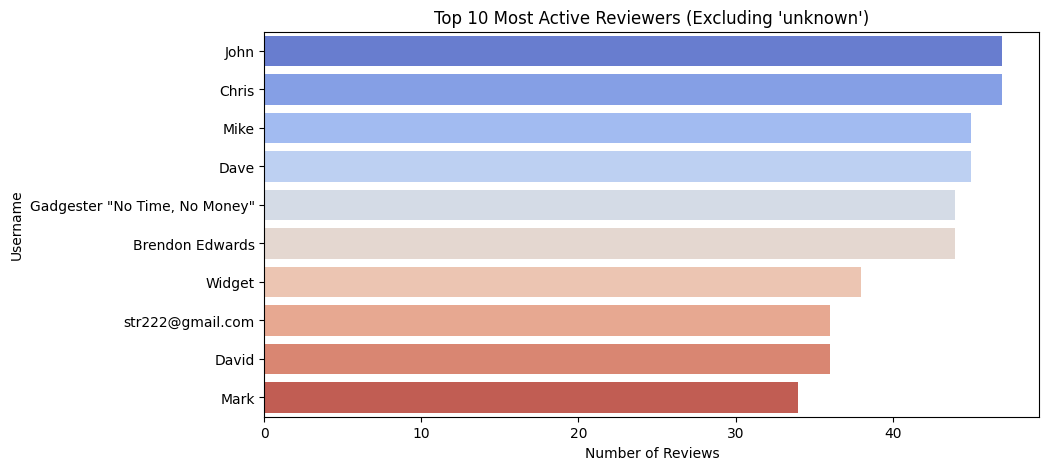

In [38]:
# Count the number of 'unknown' users
unknown_users_count = (df['username'] == 'unknown').sum()
print(f"Number of 'unknown' users: {unknown_users_count}")

# Filter out 'unknown' users
df_filtered = df[df['username'] != 'unknown']

# Get the number of reviews per user (excluding 'unknown')
reviews_per_user = df_filtered['user_id'].value_counts()
reviews_per_user_stats = reviews_per_user.describe()

print("\nSummary of Reviews Per User:")
print(reviews_per_user_stats)

# Count users with at least 5 reviews (excluding 'unknown')
users_with_5_reviews = reviews_per_user[reviews_per_user >= 5]
print(f"\nNumber of users with at least 5 reviews: {len(users_with_5_reviews)}")

# Get the top 10 most active users (excluding 'unknown')
top_reviewers = df_filtered['username'].value_counts().head(10)
print("\nTop 10 Most Active Reviewers:")
print(top_reviewers)

# Plot the top 10 most active users (excluding 'unknown')
plt.figure(figsize=(10, 5))
sns.barplot(x=top_reviewers.values, y=top_reviewers.index, palette="coolwarm")
plt.xlabel("Number of Reviews")
plt.ylabel("Username")
plt.title("Top 10 Most Active Reviewers (Excluding 'unknown')")
plt.show()




Ratings analysis

/var/folders/69/3bgwy7vx3g9g3hc8fwyj9pfh0000gn/T/ipykernel_95589/605463006.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette="viridis")


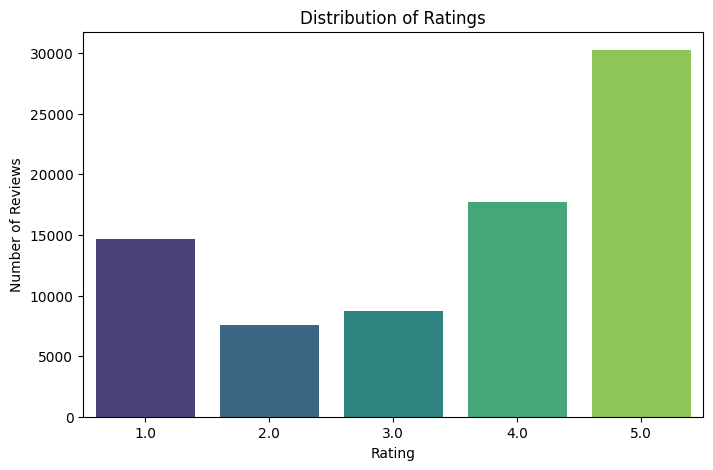


Rating Distribution:
rating
1.0    0.185924
2.0    0.095857
3.0    0.110465
4.0    0.224465
5.0    0.383289
Name: proportion, dtype: float64

Rating Statistics:
count    78930.000000
mean         3.523337
std          1.524245
min          1.000000
25%          2.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64


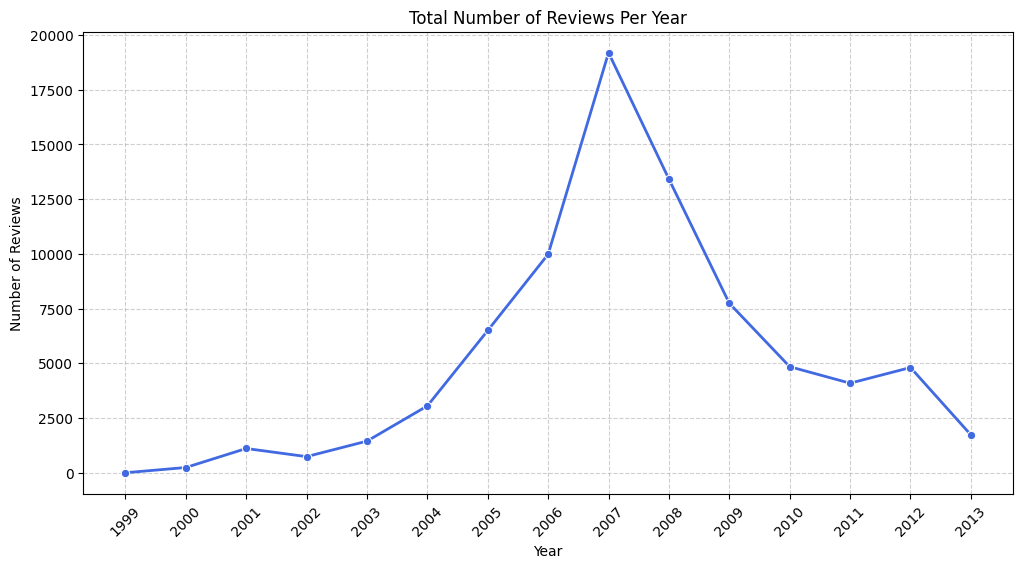

In [39]:
# Distribution of ratings
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=df, palette="viridis")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Ratings")
plt.show()

print("\nRating Distribution:")
print(df['rating'].value_counts(normalize=True).sort_index())

# Rating statistics: mean, std, min, max
print("\nRating Statistics:")
print(df['rating'].describe())



# Distribution of ratings over time
# Extract the year
df['year'] = df['review_date'].dt.year

# Aggregate the number of reviews per year
reviews_per_year = df.groupby('year').size()

# Plot the trend
plt.figure(figsize=(12, 6))
sns.lineplot(x=reviews_per_year.index, y=reviews_per_year.values, marker='o', color='royalblue', linewidth=2)

# Labels and title
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.title("Total Number of Reviews Per Year")
plt.grid(True, linestyle='--', alpha=0.6)  # Add a subtle grid
plt.xticks(reviews_per_year.index, rotation=45)  # Rotate x-axis labels for readability

# Show the plot
plt.show()


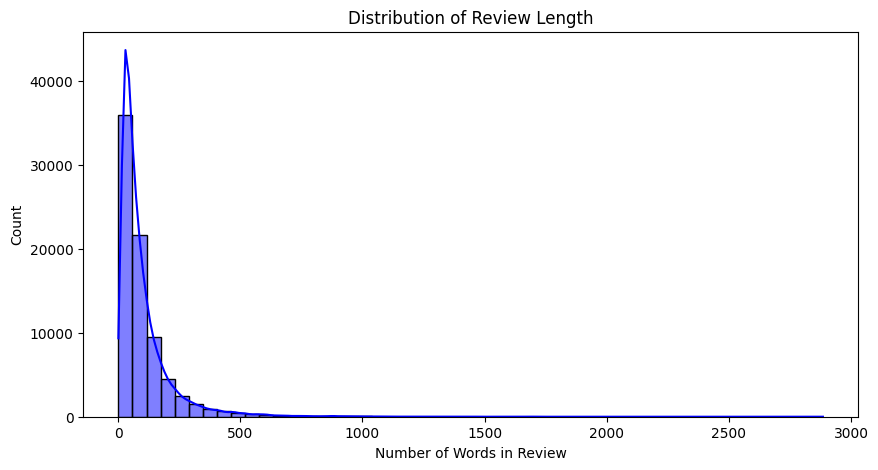


Review Length Statistics:
count    78930.000000
mean       103.243710
std        123.431139
min          1.000000
25%         34.000000
50%         65.000000
75%        123.000000
max       2885.000000
Name: review_length, dtype: float64
Number of helpful reviews: 5804
Number of not helpful reviews: 73126


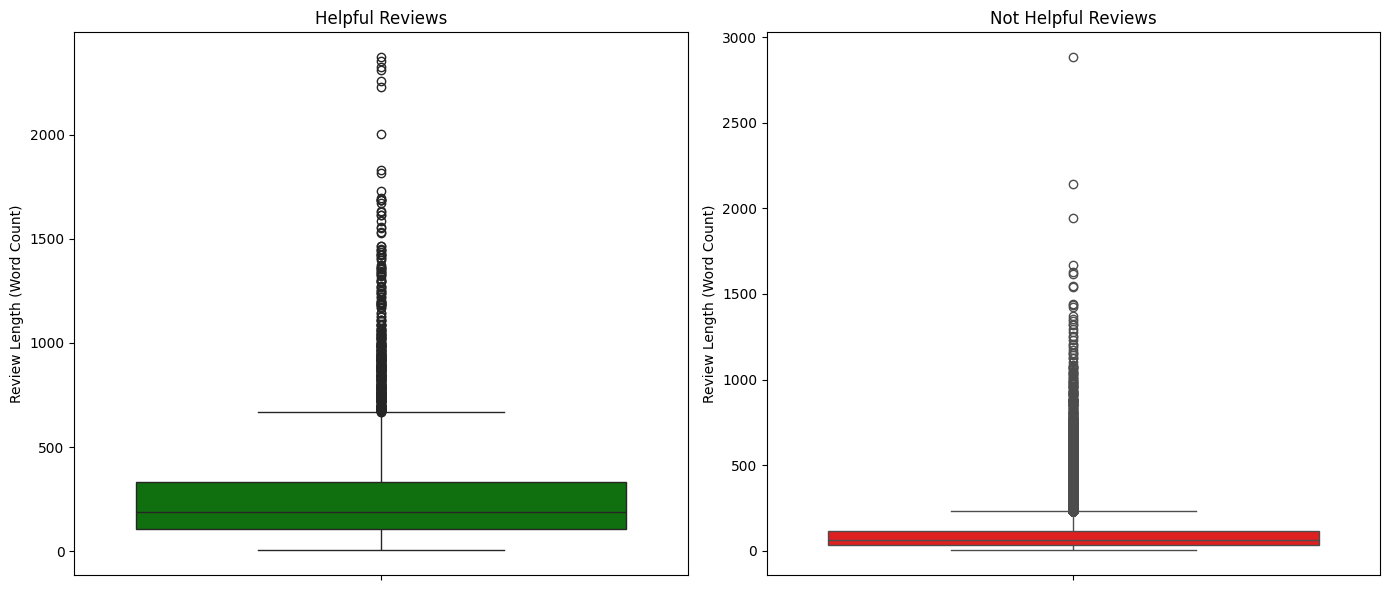

In [40]:
# Distribution of review length
df['review_length'] = df['review_text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 5))
sns.histplot(df['review_length'], bins=50, kde=True, color='blue')
plt.xlabel("Number of Words in Review")
plt.ylabel("Count")
plt.title("Distribution of Review Length")
plt.show()

# Review length statistics: mean, std, min, max
print("\nReview Length Statistics:")
print(df['review_length'].describe())


#Review Helpfulness vs. Length
# Helpful reviews: total votes >= 10 and helpful votes >= 70% of total votes
# Not helpful reviews: total votes < 10 or helpful votes < 70% of total votes
helpful_reviews = df[(df['total_votes'] >= 10) & (df['helpful_votes'] >= df['total_votes'] * 0.7)]
not_helpful_reviews = df[(df['total_votes'] < 10) | (df['helpful_votes'] < df['total_votes'] * 0.7)]

# Print the number of helpful and not helpful reviews
print(f"Number of helpful reviews: {len(helpful_reviews)}")
print(f"Number of not helpful reviews: {len(not_helpful_reviews)}")

# Wizualizacja
# Or create separate boxplots side by side with different scales
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
sns.boxplot(y=helpful_reviews['review_length'], ax=ax1, color="green")
ax1.set_title("Helpful Reviews")
ax1.set_ylabel("Review Length (Word Count)")

sns.boxplot(y=not_helpful_reviews['review_length'], ax=ax2, color="red")
ax2.set_title("Not Helpful Reviews")
ax2.set_ylabel("Review Length (Word Count)")
plt.tight_layout()
plt.show()



# Sentiment Classification

We classify the reviews as "Positive" or "Negative" based on their ratings to analyze the overall sentiment of the reviews.


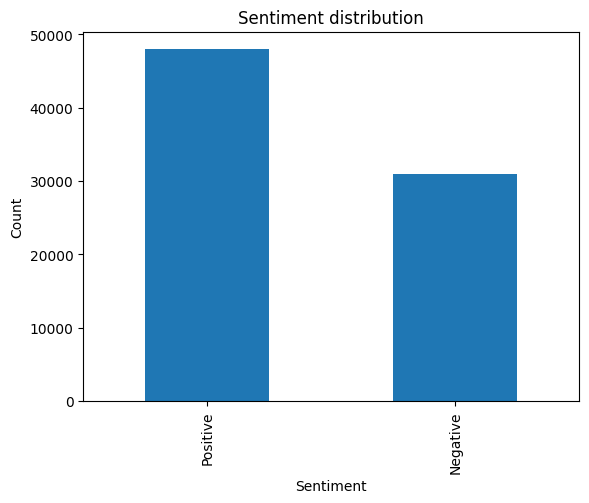

       rating sentiment
0         1.0  Negative
1         5.0  Positive
2         4.0  Positive
3         4.0  Positive
4         1.0  Negative
...       ...       ...
78925     4.0  Positive
78926     4.0  Positive
78927     5.0  Positive
78928     5.0  Positive
78929     5.0  Positive

[78930 rows x 2 columns]
sentiment
Positive    47970
Negative    30960
Name: count, dtype: int64


In [41]:
df['sentiment'] = df['rating'].apply(lambda x: 
    'Positive' if x in [4.0, 5.0] else
    'Negative'
)



sentiment_counts = df['sentiment'].value_counts()
sentiment_counts.plot(kind='bar')
plt.title('Sentiment distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


print(df[['rating', 'sentiment']])

print(df['sentiment'].value_counts())

#### Cleaning Review Text

We clean the review text by converting it to lowercase, removing special characters, numbers, punctuation, and unnecessary whitespace, to prepare the text for further analysis.


In [42]:
import re
import string

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[{}]'.format(string.punctuation), '', text) 
    text = re.sub(r'\w*\d\w*', '', text) 
    text = re.sub(r"['\"...]", '', text) 
    text = re.sub(r'\n', '', text) 
    return text

df['cleaned_text'] = df['review_text'].apply(clean_text)



print(df[['cleaned_text']].head())

                                        cleaned_text
0  first of all the company took my money and sen...
1  great product tried others and this is a ten c...
2  works real gooda little hard to set upweb part...
3  the price was right for this cable  sh compare...
4  this is not a data cable this is only a usb ch...


#### Sentiment Classification Model

We use a Logistic Regression model to classify the sentiment of the reviews. First, we vectorize the cleaned text data, then train the model on the training set and evaluate it on the test set. Finally, we display the classification report and plot the confusion matrix to assess the model's performance.


Classification report:
              precision    recall  f1-score   support

    Negative       0.82      0.78      0.80      6117
    Positive       0.87      0.89      0.88      9669

    accuracy                           0.85     15786
   macro avg       0.84      0.84      0.84     15786
weighted avg       0.85      0.85      0.85     15786



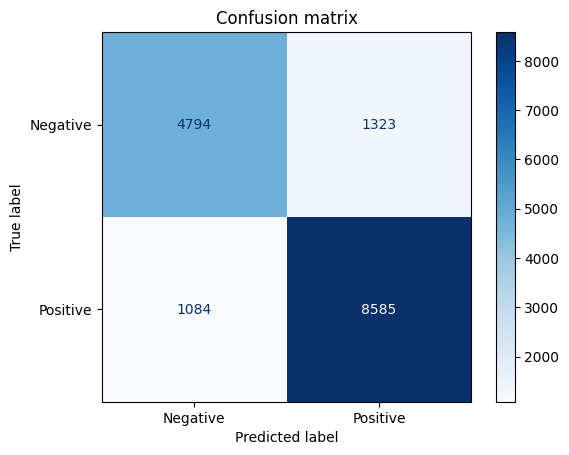

In [43]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

X = df['cleaned_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

vectorizer = CountVectorizer()

X_train_vec = vectorizer.fit_transform(X_train)

X_test_vec = vectorizer.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)

print("Classification report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.show()


#### Word Analysis for Sentiment

We analyze the words contributing to positive and negative sentiments by examining the coefficients of the Logistic Regression model. We also display the top 10 most frequent words in the training data based on their occurrence frequency.


In [44]:
import numpy as np
import pandas as pd

feature_names = vectorizer.get_feature_names_out()
coefficients = model.coef_[0]

coef_df = pd.DataFrame({'word': feature_names, 'coefficient': coefficients})

top_positive = coef_df.sort_values(by='coefficient', ascending=False).head(10)
top_negative = coef_df.sort_values(by='coefficient', ascending=True).head(10)

print("Top 10 words indicating positive sentiment:")
print(top_positive)
print("\nTop 10 words indicating negative sentiment:")
print(top_negative)


#We sum the word counts for each word in the training set to get the total frequency of each word
word_counts = np.array(X_train_vec.sum(axis=0)).flatten()
word_freq = pd.DataFrame({'word': feature_names, 'frequency': word_counts})
top_words = word_freq.sort_values(by='frequency', ascending=False).head(10)

print("\nTop 10 most frequent words:")
print(top_words)





Top 10 words indicating positive sentiment:
              word  coefficient
29915     excelent     1.935123
40063     hesitate     1.902311
49235     lipstick     1.845675
75018     restored     1.835611
33207     flawless     1.786845
84710      stepped     1.785623
50873        magic     1.776568
67787       praise     1.768257
18080  confortable     1.705473
33213   flawlessly     1.684080

Top 10 words indicating negative sentiment:
                  word  coefficient
100742           worst    -2.222196
100762       worthless    -2.141673
42745     inconsistent    -2.014985
24089   disappointment    -1.972948
24586     dissatisfied    -1.940613
94532         unusable    -1.885694
24071    disappointing    -1.874017
41931          ignored    -1.857688
65629      picturesfor    -1.836264
93364     unacceptable    -1.819039

Top 10 most frequent words:
        word  frequency
88604    the     361169
90837     to     175012
3213     and     171886
45018     it     163057
44718     is  

#### Analysis of Misclassified Reviews

We identify the misclassified reviews by comparing the predicted and actual sentiments. Then, we analyze the most frequent words in those misclassified reviews to understand common patterns or recognize potential issues with the model (eg. words like "that" or "it" that may not contribute to sentiment).


In [45]:
misclassified_idx = np.where(y_test != y_pred)[0]

misclassified_reviews = X_test.iloc[misclassified_idx]

misclassified_vec = vectorizer.transform(misclassified_reviews)

misclassified_word_counts = np.array(misclassified_vec.sum(axis=0)).flatten()
misclassified_freq = pd.DataFrame({'word': feature_names, 'frequency': misclassified_word_counts})
top_misclassified_words = misclassified_freq.sort_values(by='frequency', ascending=False).head(40)

print("Top 40 most frequent words in misclassified reviews:")
print(top_misclassified_words)



Top 40 most frequent words in misclassified reviews:
           word  frequency
88604       the      14823
90837        to       6984
45018        it       6305
3213        and       6253
44718        is       4712
64405     phone       3670
59226        of       3357
89492      this       3249
33788       for       3189
56042        my       2905
88425      that       2772
101709      you       2634
99864      with       2598
42503        in       2480
59878        on       2436
38812      have       2217
11178       but       2198
58216       not       2172
97776       was       1735
4893         as       1414
41895        if       1254
82101        so       1226
59959       one       1207
45554       its       1141
7459         be       1133
4503        are       1094
61001        or       1086
99038      when       1045
37869       had        976
95154       use        944
34654      from        924
12557       can        914
5181         at        913
36436      good        895
10

#### Model Retraining After Removing Top Misclassified Words

We identify the top 30 words from misclassified reviews and remove them from the vocabulary. After filtering the vocabulary, we retrain the Logistic Regression model using the updated vocabulary and evaluate its performance with a classification report and confusion matrix.



Classification report after removing top 30 misclassified words:
              precision    recall  f1-score   support

    Negative       0.81      0.78      0.79      6117
    Positive       0.86      0.89      0.87      9669

    accuracy                           0.84     15786
   macro avg       0.84      0.83      0.83     15786
weighted avg       0.84      0.84      0.84     15786



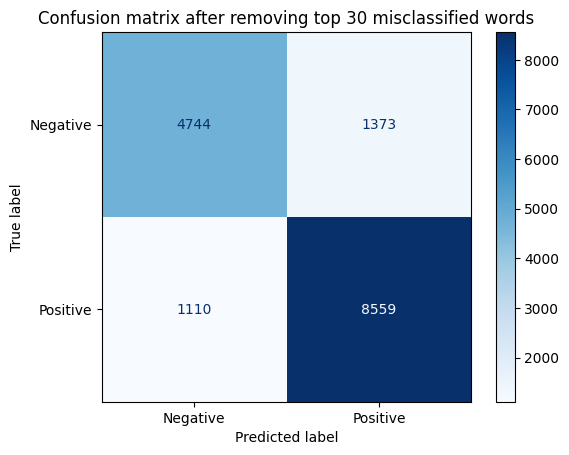

In [46]:
# We extract the top 30 words from the misclassified reviews
words_to_remove = top_misclassified_words.head(30)['word'].tolist()

# We filter the vocabulary to exclude the top 30 words
original_vocab = vectorizer.get_feature_names_out()
filtered_vocab = [word for word in original_vocab if word not in words_to_remove]

vectorizer_filtered = CountVectorizer(vocabulary=filtered_vocab)

X_train_vec_filtered = vectorizer_filtered.fit_transform(X_train)
X_test_vec_filtered = vectorizer_filtered.transform(X_test)

# We train a new model using the filtered vocabulary
model_filtered = LogisticRegression(max_iter=1000)
model_filtered.fit(X_train_vec_filtered, y_train)
y_pred_filtered = model_filtered.predict(X_test_vec_filtered)

print("\nClassification report after removing top 30 misclassified words:")
print(classification_report(y_test, y_pred_filtered))

# We plot the confusion matrix
cm_filtered = confusion_matrix(y_test, y_pred_filtered, labels=model_filtered.classes_)
disp_filtered = ConfusionMatrixDisplay(confusion_matrix=cm_filtered, display_labels=model_filtered.classes_)
disp_filtered.plot(cmap=plt.cm.Blues)
plt.title("Confusion matrix after removing top 30 misclassified words")
plt.show()

#### Model Retraining After Stop words

We remove stop words from the vocabulary and retrain the Logistic Regression model. We evaluate the model's performance with a classification report and confusion matrix to compare it with the previous models.



Classification report after removing stop words:
              precision    recall  f1-score   support

    Negative       0.80      0.77      0.79      6117
    Positive       0.86      0.88      0.87      9669

    accuracy                           0.84     15786
   macro avg       0.83      0.83      0.83     15786
weighted avg       0.84      0.84      0.84     15786



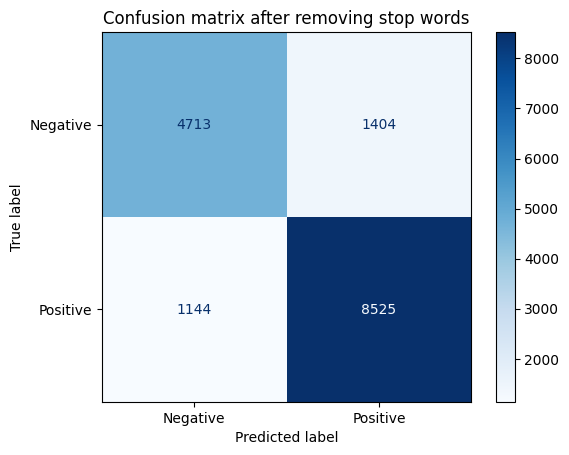

In [47]:
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#we're using set from sklearn
stop_words = set(ENGLISH_STOP_WORDS)
original_vocab = vectorizer.get_feature_names_out()


filtered_vocab = [word for word in original_vocab if word not in stop_words]
vectorizer_filtered = CountVectorizer(vocabulary=filtered_vocab)

X_train_vec_filtered = vectorizer_filtered.fit_transform(X_train)
X_test_vec_filtered = vectorizer_filtered.transform(X_test)

model_filtered = LogisticRegression(max_iter=1000)
model_filtered.fit(X_train_vec_filtered, y_train)
y_pred_filtered = model_filtered.predict(X_test_vec_filtered)

print("\nClassification report after removing stop words:")
print(classification_report(y_test, y_pred_filtered))

cm_filtered = confusion_matrix(y_test, y_pred_filtered, labels=model_filtered.classes_)
disp_filtered = ConfusionMatrixDisplay(confusion_matrix=cm_filtered, display_labels=model_filtered.classes_)
disp_filtered.plot(cmap=plt.cm.Blues)
plt.title("Confusion matrix after removing stop words")
plt.show()


#### Testing Multiple Models

We test and evaluate four different machine learning models (Logistic Regression, Multinomial Naive Bayes, Linear SVC, and Random Forest) using a pipeline that includes text vectorization with `CountVectorizer`. Each model is trained and evaluated, and we check the classification report for each.


In [48]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Testing multiple models
pipelines = {
    "Logistic Regression": Pipeline([('vectorizer', CountVectorizer()), 
                                       ('classifier', LogisticRegression(max_iter=1000))]),
    "Multinomial NB": Pipeline([('vectorizer', CountVectorizer()), 
                                ('classifier', MultinomialNB())]),
    "Linear SVC": Pipeline([('vectorizer', CountVectorizer()), 
                             ('classifier', LinearSVC())]),
    "Random Forest": Pipeline([('vectorizer', CountVectorizer()), 
                                ('classifier', RandomForestClassifier(n_estimators=100))])
}

# Training and evaluating each model
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(f"\n{name} classification report:")
    print(classification_report(y_test, y_pred))



Logistic Regression classification report:
              precision    recall  f1-score   support

    Negative       0.82      0.78      0.80      6117
    Positive       0.87      0.89      0.88      9669

    accuracy                           0.85     15786
   macro avg       0.84      0.84      0.84     15786
weighted avg       0.85      0.85      0.85     15786


Multinomial NB classification report:
              precision    recall  f1-score   support

    Negative       0.79      0.73      0.76      6117
    Positive       0.84      0.88      0.86      9669

    accuracy                           0.82     15786
   macro avg       0.82      0.81      0.81     15786
weighted avg       0.82      0.82      0.82     15786



/opt/homebrew/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Linear SVC classification report:
              precision    recall  f1-score   support

    Negative       0.78      0.77      0.78      6117
    Positive       0.86      0.86      0.86      9669

    accuracy                           0.83     15786
   macro avg       0.82      0.82      0.82     15786
weighted avg       0.83      0.83      0.83     15786


Random Forest classification report:
              precision    recall  f1-score   support

    Negative       0.87      0.59      0.71      6117
    Positive       0.79      0.94      0.86      9669

    accuracy                           0.81     15786
   macro avg       0.83      0.77      0.78     15786
weighted avg       0.82      0.81      0.80     15786



# Reviews Clustering

We use K-Means clustering to group reviews into 5 clusters based on their cleaned text. The text is vectorized using TF-IDF, and the clusters are visualized in a 2D space using PCA. We also display the top 10 terms for each cluster to understand the key themes.


                                        cleaned_text  cluster
0  first of all the company took my money and sen...        1
1  great product tried others and this is a ten c...        1
2  works real gooda little hard to set upweb part...        1
3  the price was right for this cable  sh compare...        1
4  this is not a data cable this is only a usb ch...        1


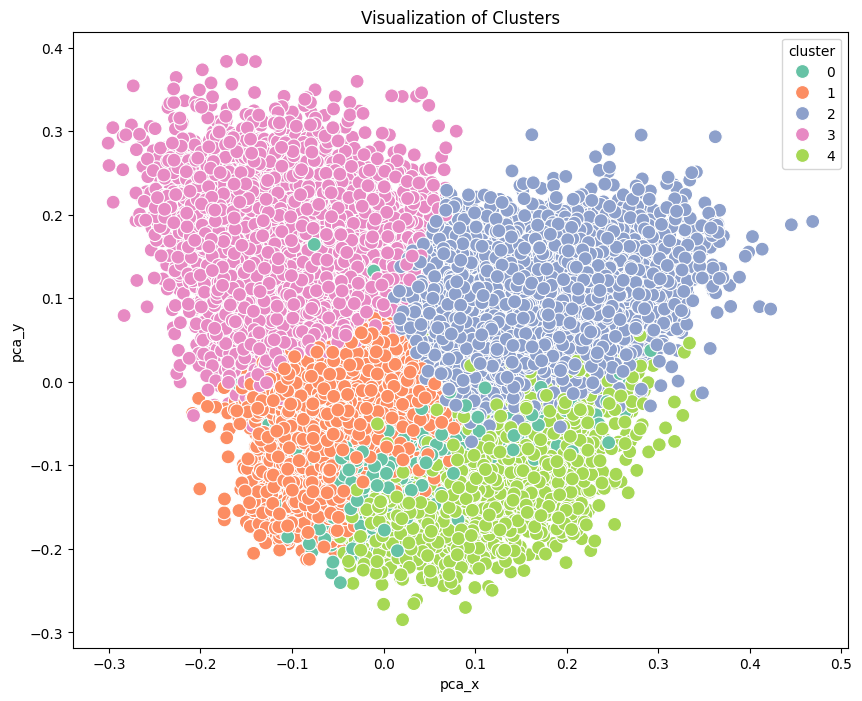

Top terms per cluster:
Cluster 0:
case, clip, phone, belt, leather, fits, fit, like, great, good

Cluster 1:
product, great, works, charger, phone, good, work, price, use, just

Cluster 2:
phone, great, camera, use, good, phones, like, just, screen, dont

Cluster 3:
headset, ear, sound, bluetooth, quality, hear, good, great, use, comfortable

Cluster 4:
battery, charge, phone, new, original, life, great, old, batteries, works



In [49]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

X = df['cleaned_text']
n_clusters = 5

vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)  
X = vectorizer.fit_transform(df['cleaned_text'])

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X)

df['cluster'] = kmeans.labels_

print(df[['cleaned_text', 'cluster']].head())

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X.toarray())

df['pca_x'] = reduced_data[:, 0]
df['pca_y'] = reduced_data[:, 1]


plt.figure(figsize=(10, 8))
sns.scatterplot(x='pca_x', y='pca_y', hue='cluster', data=df, palette="Set2", s=100)
plt.title("Visualization of Clusters")
plt.show()


terms = vectorizer.get_feature_names_out()

print("Top terms per cluster:")
for i in range(n_clusters):
    print(f"Cluster {i}:")
    cluster_centroids = kmeans.cluster_centers_[i]
    sorted_indices = cluster_centroids.argsort()[-10:][::-1]
    top_terms = [terms[ind] for ind in sorted_indices]
    print(", ".join(top_terms))
    print()


#### Getting neighbor clusters

In [50]:
from sklearn.metrics.pairwise import cosine_distances

# Calculate cluster centroids
centroids = kmeans.cluster_centers_

# Function to calculate similar clusters based on cosine distance
def get_neighbor_clusters(cluster_centroids, cluster_id, n_neighbors=3):
    # Calculate cosine distance between centroids
    distances = cosine_distances([cluster_centroids[cluster_id]], cluster_centroids)
    distances = distances.flatten()  
    distances[cluster_id] = np.inf  
    
    # Select n_neighbors closest clusters
    closest_clusters = distances.argsort()[:n_neighbors]
    
    return closest_clusters

# Example: finding similar clusters for cluster with id 3
cluster_id = 3
neighbor_clusters = get_neighbor_clusters(centroids, cluster_id)
print(f"Neighbor clusters for cluster {cluster_id}: {neighbor_clusters}")

Neighbor clusters for cluster 3: [1 2 4]


In [51]:
#Printing sample reviews from each cluster
print("Example reviews from each cluster:")
for i in range(n_clusters):
    print(f"\nCluster {i} sample reviews:")
    cluster_reviews = df[df['cluster'] == i]['cleaned_text'].head(10)
    for review in cluster_reviews:
        print(f"- {review}")

Example reviews from each cluster:

Cluster 0 sample reviews:
- great case cingular should get their cases from this supplier cingulars case is sorry cant use that word
- well constructed case of good quality leather looks works just fine however my wife broke the belt clip on hers in under  month i broke mine in under a year my guess is if you never dropped your cellphone is that possible you would never have any serious complaints with this case im here now to order another oneand theyre on sale hooray
- this case offers very little protection and most of the phone is exposed not worth it
- received case well packaged and fast shipping the case itself form fits phone fine but does not snap well together the first time i tried one of the top tabs broke so for temporary purposes until i get a new case i used a dab of gorilla glue to hold the upper two halves together obviously if i have to reset the phone this will be the end of the case only  bucks but i would put that money towards a

# Recommendation System

This code defines a recommendation system using K-means clustering, where products are grouped into clusters based on similarity. It suggests products either from the same or neighboring clusters using the find_similar_cluster_products method, or provides personalized recommendations based on a user's previous ratings with user_personalized_recommendations. Products are ranked using a composite score considering rating, review count, and helpful votes. The system also displays the average rating for similar products, making recommendations more informative.

In [52]:
import numpy as np

class ProductClusterRecommendationSystem:
    def __init__(self, df, terms, kmeans, centroids):
        self.df = df
        self.terms = terms
        self.kmeans = kmeans
        self.centroids = centroids
    
    def find_similar_cluster_products(self, product_id, top_n=5):

        # Get the cluster of the product
        product_cluster = self.df[self.df['product_id'] == product_id]['cluster'].iloc[0]
        
        # Get neighbor clusters of the product's cluster
        neighbor_clusters = get_neighbor_clusters(self.centroids, product_cluster) 
        
        # Get products from the neighbor clusters
        similar_products_df = self.df[
            self.df['cluster'].isin(neighbor_clusters) & 
            (self.df['product_id'] != product_id)
        ]
        
        # Get the composite score for each product
        product_scores = (
            similar_products_df
            .groupby('product_id')
            .agg({
                'rating': ['mean', 'count'],
                'helpful_votes': 'sum'
            })
        )
        
        product_scores.columns = ['rating_mean', 'rating_count', 'helpful_votes']
        
        # Calculate composite score
        product_scores['composite_score'] = (
            product_scores['rating_mean'] * 1.2 + 
            np.log1p(product_scores['rating_count']) * 0.3 + 
            np.log1p(product_scores['helpful_votes']) * 0.1
        )
        
        # Get top N recommendations
        recommendations = product_scores.sort_values(
            by='composite_score', 
            ascending=False
        ).head(top_n)
        
        return list(recommendations.index)
    
    def user_personalized_recommendations(self, user_id, top_n=5):

        # Get products rated by the user
        user_rated_products = self.df[
            self.df['user_id'] == user_id
        ]['product_id'].unique()
        
        # Get clusters of products rated by the user
        user_product_clusters = self.df[
            self.df['user_id'] == user_id
        ]['cluster'].unique()
        
        # Get neighbor clusters of the user's clusters
        neighbor_clusters = []
        for cluster in user_product_clusters:
            neighbor_clusters.extend(get_neighbor_clusters(self.centroids, cluster))  
        
        # Combine user's clusters and neighbor clusters
        all_clusters = list(set(user_product_clusters + neighbor_clusters))
        
        # Get recommendations from the combined clusters
        recommendations_pool = self.df[
            ~self.df['product_id'].isin(user_rated_products) &
            self.df['cluster'].isin(all_clusters)
        ]
        
        # Calculate composite scores for recommendations
        product_scores = (
            recommendations_pool
            .groupby('product_id')
            .agg({
                'rating': ['mean', 'count'],
                'helpful_votes': 'sum'
            })
        )
        
        product_scores.columns = ['rating_mean', 'rating_count', 'helpful_votes']
        
        # Calculate composite score
        product_scores['composite_score'] = (
            product_scores['rating_mean'] * 1.2 +
            np.log1p(product_scores['rating_count']) * 0.3 +
            np.log1p(product_scores['helpful_votes']) * 0.1
        )
        
        # Get top N recommendations
        recommendations = product_scores.sort_values(
            by='composite_score', 
            ascending=False
        ).head(top_n)
        
        return list(recommendations.index)

# Example usage
recommender = ProductClusterRecommendationSystem(df, terms, kmeans, kmeans.cluster_centers_)

# 1. Personalized recommendations for user
user_id = df['user_id'].sample(1).values[0]
user_recommendations = recommender.user_personalized_recommendations(user_id)
print(f"\nRecommendations for user {user_id}:", user_recommendations)


# 2. Find similar products
product_id = df['product_id'].sample(1).values[0]
similar_products = recommender.find_similar_cluster_products(product_id)

# Get the information for the similar products (including all ratings)
similar_products_info = df[df['product_id'].isin(similar_products)][['product_id', 'product_name', 'rating']]

# Calculate the average rating for each product
average_ratings = similar_products_info.groupby(['product_id', 'product_name'])['rating'].mean().reset_index()

# Print the similar products with their names and average ratings
print(f"\nSimilar products to {product_id}: Name: {df[df['product_id'] == product_id]['product_name'].iloc[0]}")
for _, row in average_ratings.iterrows():
    print(f"Product ID: {row['product_id']}, Name: {row['product_name']}, Average Rating: {row['rating']:.2f}")




Recommendations for user A78MF017X8T7U: ['B0009B0IX4', 'B000BHAUSE', 'B000GAO9T2', 'B0009OAP8O', 'B000Q6R4MK']

Similar products to B000KFWUMG: Name: Cingular 8525 PDA Phone
Product ID: B0009B0IX4, Name: Plantronics Voyager 510 Bluetooth Headset [Retail Packaging], Average Rating: 4.16
Product ID: B000BHAUSE, Name: VXI CORPORATION B150 Bluetooth Headset and Charger for Cell Phones and PC, Average Rating: 4.50
Product ID: B000FEHG76, Name: BlackBerry 8700g Phone (T-Mobile), Average Rating: 4.45
Product ID: B000J2FOF0, Name: Sony Ericsson W810i Phone (AT&T, Phone Only, No Service), Average Rating: 4.07
Product ID: B000Q6R4MK, Name: BlueAnt Supertooth Light Bluetooth Speakerphone (Black), Average Rating: 4.06


#### Plot

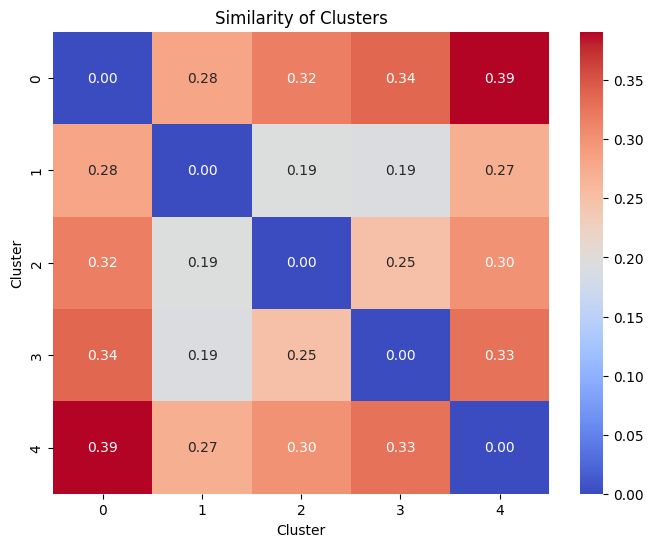

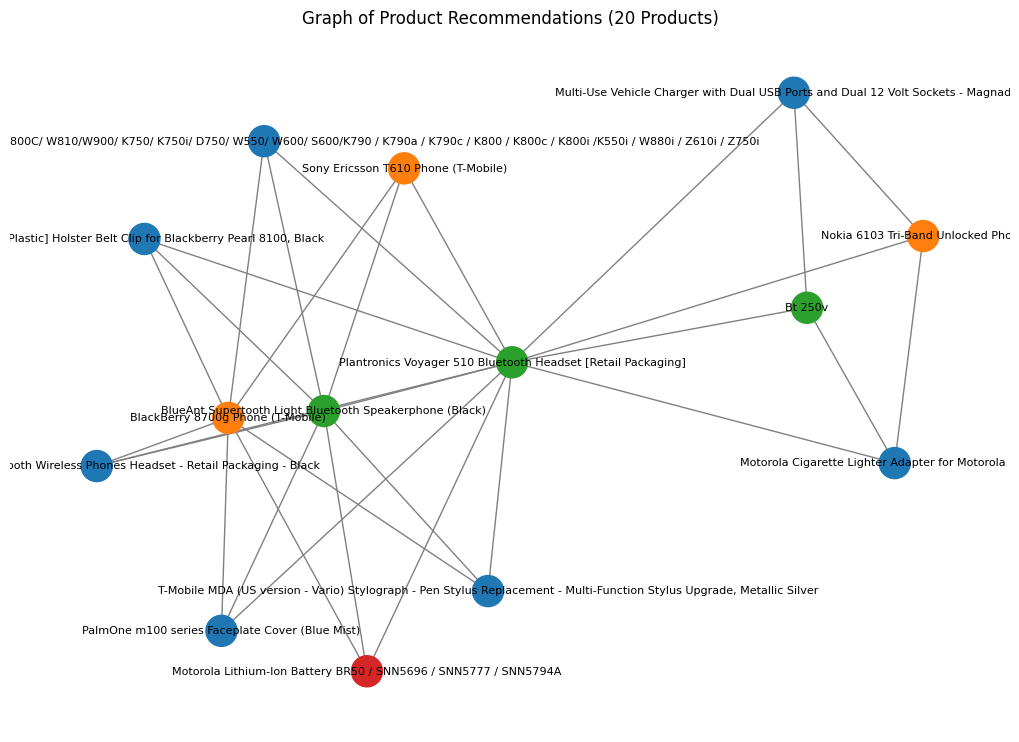

In [53]:
import seaborn as sns

def plot_cluster_similarity(centroids):
    from scipy.spatial.distance import cdist
    
    # Obliczamy odległości między centroidami
    distance_matrix = cdist(centroids, centroids, metric='euclidean')
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(distance_matrix, cmap='coolwarm', annot=True, fmt=".2f")
    plt.title('Similarity of Clusters')
    plt.xlabel('Cluster')
    plt.ylabel('Cluster')
    plt.show()

# Wizualizacja podobieństwa klastrów
plot_cluster_similarity(kmeans.cluster_centers_)


import networkx as nx
import matplotlib.pyplot as plt

def plot_recommendation_graph(df, recommender, num_products=10):
    G = nx.Graph()

    # Wybierz losowe produkty
    sampled_products = df.sample(num_products)

    # Słownik do przechowywania klastrów
    product_clusters = {}

    # Dodaj produkty jako węzły
    for _, row in sampled_products.iterrows():
        product_id = row['product_id']
        product_name = row['product_name']
        cluster = row['cluster']

        # Dodaj węzeł do grafu z atrybutem cluster
        G.add_node(product_name)
        product_clusters[product_name] = cluster

        # Pobierz rekomendacje dla danego produktu
        similar_products = recommender.find_similar_cluster_products(product_id, top_n=3)

        # Połącz produkt z jego rekomendacjami (jeśli istnieją w df)
        for similar_id in similar_products:
            if similar_id in df['product_id'].values:  # Sprawdzenie, czy produkt istnieje
                similar_name = df[df['product_id'] == similar_id]['product_name'].iloc[0]
                G.add_edge(product_name, similar_name)
                product_clusters[similar_name] = df[df['product_id'] == similar_id]['cluster'].iloc[0]

    # Pobierz unikalne klastry
    unique_clusters = set(product_clusters.values())
    cluster_colors = {cluster: f"C{idx}" for idx, cluster in enumerate(unique_clusters)}

    # Kolory dla węzłów
    node_colors = [cluster_colors[product_clusters[n]] for n in G.nodes]

    # Rysowanie grafu
    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=500, edge_color='gray', font_size=8)

    plt.title("Graph of Product Recommendations (20 Products)")
    plt.show()

# Wywołanie funkcji
plot_recommendation_graph(df, recommender, num_products=10)



# Rating Prediction with PyTorch

#### Dataset Class for Recommendation System in PyTorch
This code defines a custom Dataset class for a recommendation system using PyTorch. It processes a DataFrame containing user-product interactions, storing the user and product indices, ratings, as well as user and product biases. The class prepares the data for model training by providing the necessary information, such as biases and global mean, which are then returned in a format suitable for neural network input.

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

class RecommendationDataset(Dataset):
    def __init__(self, df, user_bias_dict, product_bias_dict, global_mean):
        self.users = df['user_idx'].values
        self.products = df['product_idx'].values
        self.ratings = df['rating'].values.astype(np.float32)
        self.user_bias_dict = user_bias_dict
        self.product_bias_dict = product_bias_dict
        self.global_mean = global_mean
        
    def __len__(self):
        return len(self.ratings)
        
    def __getitem__(self, idx):
        user_idx = self.users[idx]
        product_idx = self.products[idx]
        rating = self.ratings[idx]
        
        # Getting biases
        user_bias = self.user_bias_dict.get(user_idx, 0)
        product_bias = self.product_bias_dict.get(product_idx, 0)
        
        return (torch.tensor(user_idx),
                torch.tensor(product_idx),
                torch.tensor(rating),
                torch.tensor(user_bias, dtype=torch.float32),
                torch.tensor(product_bias, dtype=torch.float32),
                torch.tensor(self.global_mean, dtype=torch.float32))

#### Neural Network Model for Predicting User-Product Ratings in a Recommendation System

This code defines a neural network model for a recommendation system, designed to predict ratings for user-product pairs. It uses embeddings for both users and products and a multi-layer perceptron (MLP) to learn the relationship between them. The model is optimized with regularized weight initialization to improve prediction accuracy and stability during training.

In [55]:
class NCF(nn.Module):
    def __init__(self, num_users, num_products, embedding_dim=32):
        super(NCF, self).__init__()
        # Reduced embedding dimension
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.product_embedding = nn.Embedding(num_products, embedding_dim)
        
        # Simplified MLP architecture
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim * 2 + 2, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )
        
        # Improved weight initialization
        for layer in self.mlp:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
                nn.init.zeros_(layer.bias)
        
        # Regularized embedding initialization
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.product_embedding.weight)
    
    def forward(self, user, product, user_bias, product_bias):
        user_emb = self.user_embedding(user)
        product_emb = self.product_embedding(product)
        
        x = torch.cat([user_emb, product_emb, user_bias.unsqueeze(1), product_bias.unsqueeze(1)], dim=-1)
        
        return self.mlp(x).squeeze()

#### Custom Loss Function and Data Preparation for Recommendation System

This code defines a custom loss function (BiasedLoss) that combines mean squared error (MSE) with a regularization term for user and product biases to improve model generalization. It also includes an early stopping mechanism (EarlyStopping) to halt training when the validation loss stops improving for a specified number of epochs. Additionally, the prepare_recommendation_data function processes and filters the raw data, maps user and product IDs to indices, and calculates global ratings, biases, and other necessary components for training a recommendation system

In [56]:
class BiasedLoss(nn.Module):
    def __init__(self, bias_reg_weight=0.05):
        super(BiasedLoss, self).__init__()
        self.mse = nn.MSELoss()
        self.bias_reg_weight = bias_reg_weight
    
    def forward(self, pred, true, user_bias, product_bias, global_mean):
        base_loss = self.mse(pred, true)
        bias_regularization = self.bias_reg_weight * (
            torch.mean(user_bias**2) + 
            torch.mean(product_bias**2)
        )
        return base_loss + bias_regularization

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def prepare_recommendation_data(df, min_reviews_user=0, min_reviews_product=0):
    # User filtering
    user_counts = df['user_id'].value_counts()
    valid_users = user_counts[user_counts >= min_reviews_user].index
    df_filtered = df[df['user_id'].isin(valid_users)]

    # Product filtering
    product_counts = df_filtered['product_id'].value_counts()
    valid_products = product_counts[product_counts >= min_reviews_product].index
    df_filtered = df_filtered[df_filtered['product_id'].isin(valid_products)]

    print("Number of users after filtering:", df_filtered['user_id'].nunique())
    print("Number of products after filtering:", df_filtered['product_id'].nunique())
    print("Average rating after filtering:", df_filtered['rating'].mean())

    # Mapping identifiers
    user_map = {user: idx for idx, user in enumerate(df_filtered['user_id'].unique())}
    product_map = {product: idx for idx, product in enumerate(df_filtered['product_id'].unique())}

    df_filtered['user_idx'] = df_filtered['user_id'].map(user_map)
    df_filtered['product_idx'] = df_filtered['product_id'].map(product_map)

    # Calculating global mean and biases
    global_mean = df_filtered['rating'].mean()
    user_bias = df_filtered.groupby('user_idx')['rating'].mean() - global_mean
    product_bias = df_filtered.groupby('product_idx')['rating'].mean() - global_mean

    # Convert to dictionaries for easy access
    user_bias_dict = user_bias.to_dict()
    product_bias_dict = product_bias.to_dict()

    return df_filtered, user_map, product_map, user_bias_dict, product_bias_dict, global_mean

#### Training and Evaluation of Neural Collaborative Filtering (NCF) Model

This code defines a training pipeline for the Neural Collaborative Filtering (NCF) model, which uses embeddings for users and products to predict ratings. The train_ncf_model function performs training for a set number of epochs, evaluates the model on validation data, applies early stopping to prevent overfitting, and uses learning rate scheduling. The main function prepares the recommendation dataset, splits it into training and testing sets, and initializes the data loaders before training the NCF model.

Number of users after filtering: 68041
Number of products after filtering: 7438
Average rating after filtering: 3.5233371341695174
Epoch 1/30, Train Loss: 1.0847, Val Loss: 0.3540, RMSE: 0.4758, MAE: 0.2611
Epoch 2/30, Train Loss: 0.4938, Val Loss: 0.3334, RMSE: 0.4539, MAE: 0.2166
Epoch 3/30, Train Loss: 0.4436, Val Loss: 0.3327, RMSE: 0.4531, MAE: 0.2081
Epoch 4/30, Train Loss: 0.4125, Val Loss: 0.3406, RMSE: 0.4620, MAE: 0.2203
Epoch 5/30, Train Loss: 0.3857, Val Loss: 0.3531, RMSE: 0.4755, MAE: 0.2161
Epoch 6/30, Train Loss: 0.3663, Val Loss: 0.3553, RMSE: 0.4777, MAE: 0.2069
Epoch 7/30, Train Loss: 0.3563, Val Loss: 0.3712, RMSE: 0.4941, MAE: 0.2326
Early stopping triggered


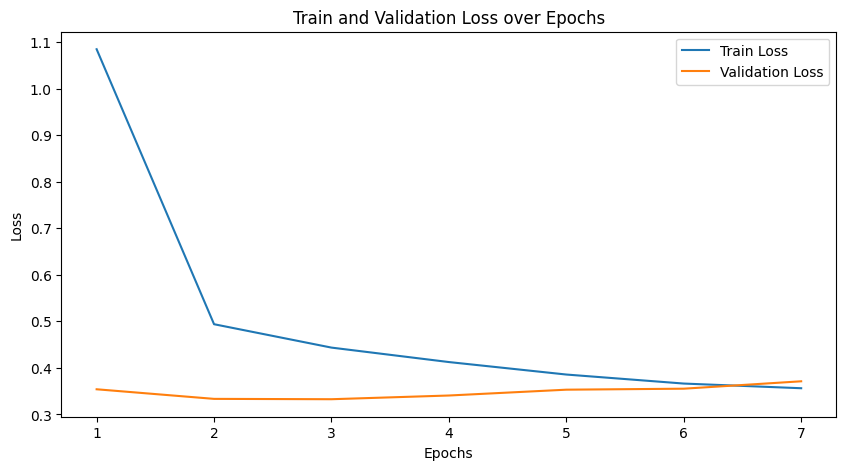

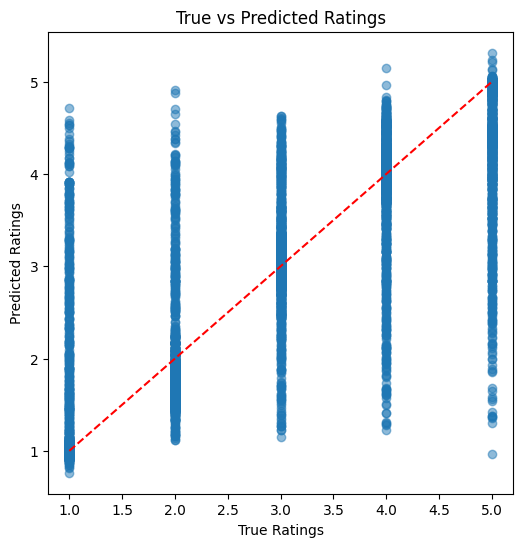

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

def train_ncf_model(train_dataloader, test_dataloader, num_users, num_products, epochs=30):
    model = NCF(num_users, num_products, embedding_dim=32)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    loss_fn = BiasedLoss()
    early_stopping = EarlyStopping(patience=5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    train_losses = []
    val_losses = []
    rmses = []
    maes = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for user, product, rating, user_bias, product_bias, global_mean in train_dataloader:
            optimizer.zero_grad()
            predicted_rating = model(user, product, user_bias, product_bias)
            loss = loss_fn(predicted_rating, rating, user_bias, product_bias, global_mean)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        y_true, y_pred = [], []
        
        with torch.no_grad():
            for user, product, rating, user_bias, product_bias, global_mean in test_dataloader:
                predicted_rating = model(user, product, user_bias, product_bias)
                loss = loss_fn(predicted_rating, rating, user_bias, product_bias, global_mean)
                val_loss += loss.item()
                y_true.extend(rating.numpy())
                y_pred.extend(predicted_rating.numpy())
        
        val_loss /= len(test_dataloader)
        val_losses.append(val_loss)

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        rmses.append(rmse)
        maes.append(mae)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}')
        
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break



    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss over Epochs')
    plt.legend()


    # Scatter plot of true vs predicted ratings
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
    plt.xlabel('True Ratings')
    plt.ylabel('Predicted Ratings')
    plt.title('True vs Predicted Ratings')
    plt.show()

    return model

def main():
    # Prepare the data
    df_filtered, user_map, product_map, user_bias_dict, product_bias_dict, global_mean = prepare_recommendation_data(df)

    # Split the data
    train_df, test_df = train_test_split(df_filtered, test_size=0.2, random_state=42)

    # Create datasets
    train_dataset = RecommendationDataset(train_df, user_bias_dict, product_bias_dict, global_mean)
    test_dataset = RecommendationDataset(test_df, user_bias_dict, product_bias_dict, global_mean)

    # Create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    # Train the model
    model = train_ncf_model(
        train_dataloader, 
        test_dataloader, 
        num_users=len(user_map), 
        num_products=len(product_map)
    )

    #save the trained model if needed
    torch.save(model.state_dict(), 'ncf_model.pth')

    return model

if __name__ == "__main__":
    trained_model = main()


# Word Embedding NLP

#### Creatin model for word embedding with Word2Vec

We create a Word2Vec model using the Gensim library to generate word embeddings from the review text. The model is trained on the cleaned review text data to learn the relationships between words and create dense vector representations for each word in the vocabulary.

Words similar to 'bad': [('good', 0.7084019780158997), ('terrible', 0.6833688616752625), ('horrible', 0.6812030076980591), ('shabby', 0.6811701655387878), ('poor', 0.6571218371391296), ('lousy', 0.6527166962623596), ('crappy', 0.6257196664810181), ('awful', 0.5998207330703735), ('stinks', 0.5996677279472351), ('disappointing', 0.5857180953025818)]
Similarity between 'good' and 'great': 0.79164433
Similarity between 'fast' and 'quick': 0.78436077
Odd one out: bad
Word2Vec<vocab=27773, vector_size=100, alpha=0.025>


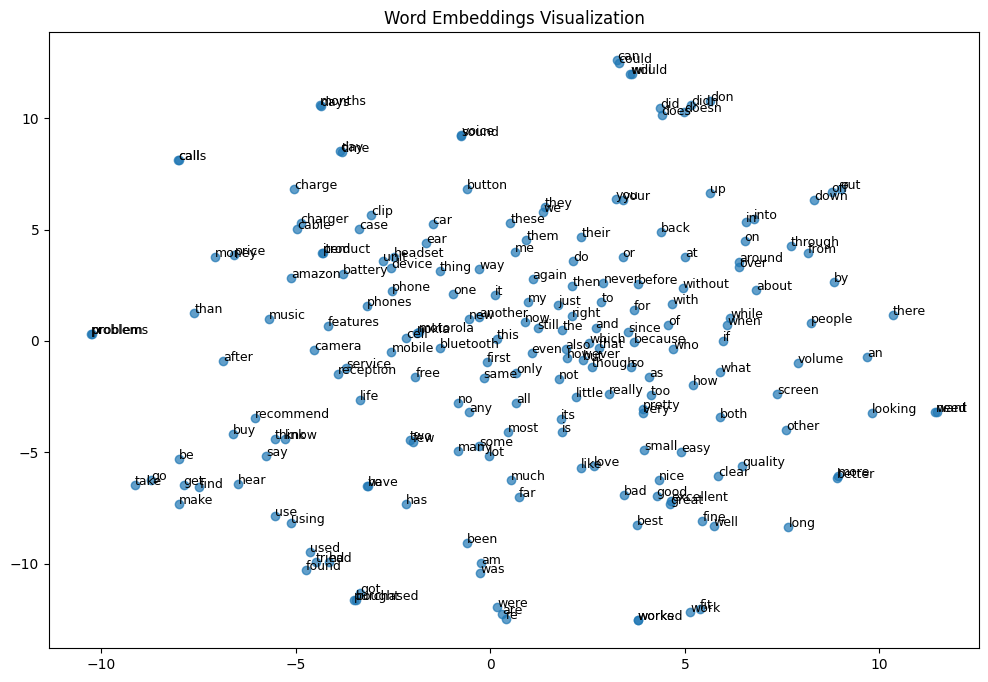

In [66]:
import gensim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


# Combine review summary and text
df['full_text'] = df['review_summary'].astype(str) + " " + df['review_text'].astype(str)

# Tokenize the text
review_text = df['full_text'].apply(gensim.utils.simple_preprocess)

# Train the Word2Vec model
model = gensim.models.Word2Vec(
    vector_size=100, 
    window=5,  
    min_count=2,  
    workers=4, 
    epochs=15 
)

# Build the vocabulary
model.build_vocab(review_text, progress_per=1000)
model.train(review_text, total_examples=model.corpus_count, epochs=model.epochs)

# Check similarity between words
print("Words similar to 'bad':", model.wv.most_similar("bad"))
print("Similarity between 'good' and 'great':", model.wv.similarity("good", "great"))
print("Similarity between 'fast' and 'quick':", model.wv.similarity("fast", "quick"))

# Find the odd one out
print("Odd one out:", model.wv.doesnt_match(['good', 'great', 'fantastic', 'bad']))

# Print model statistics
print(model)

# Save the model
model.save("word2vec_reviews.model")



#Visualizing Word Embeddings

# Load 200 random words
words = list(model.wv.key_to_index.keys())[:200]
word_vectors = np.array([model.wv[word] for word in words])

# Reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
word_vecs_2d = tsne.fit_transform(word_vectors)

plt.figure(figsize=(12, 8))
plt.scatter(word_vecs_2d[:, 0], word_vecs_2d[:, 1], alpha=0.7)

# Add word annotations
for i, word in enumerate(words):
    plt.annotate(word, xy=(word_vecs_2d[i, 0], word_vecs_2d[i, 1]), fontsize=9)

plt.title("Word Embeddings Visualization")
plt.show()


#### Sentiment Analysis with Word Embeddings

After loading the pre-trained GloVe word embeddings, we preprocess the text data by tokenizing and padding the sequences. We then create a neural network model using an embedding layer, LSTM layer, and dense layer for sentiment analysis. The model is trained on the training data and evaluated on the test data to classify reviews as positive or negative.

Unforounately, the sentiment prediction model is not working as expected and is worse than original.

Classification report:
              precision    recall  f1-score   support

    Negative       0.75      0.69      0.72      6117
    Positive       0.81      0.86      0.83      9669

    accuracy                           0.79     15786
   macro avg       0.78      0.77      0.78     15786
weighted avg       0.79      0.79      0.79     15786



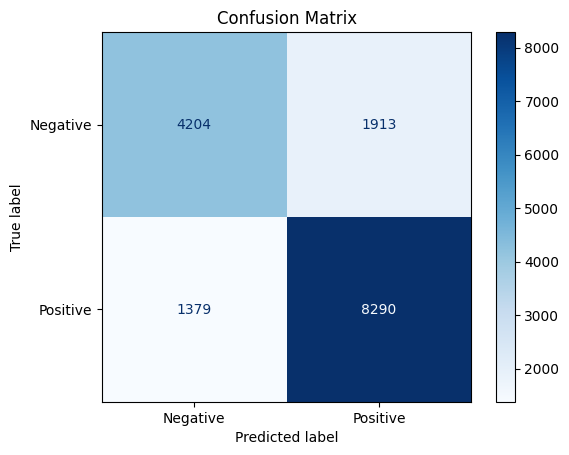

In [ ]:


import gensim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Tokenize the text
def get_mean_vector(text, model):
    words = text.split()  
    vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Create a mean vector for each review
df['vector'] = df['full_text'].apply(lambda x: get_mean_vector(x, model))

X = np.vstack(df['vector'].values)
y = df['sentiment']


# Train regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Show classification report
print("Classification report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



#### Product feature extraction with Word Embeddings

In [ ]:
import numpy as np
import gensim
from collections import Counter, defaultdict

def extract_product_features(df, model, top_n=10):
    # Preprocess and tokenize reviews
    df['tokenized_reviews'] = df['full_text'].apply(gensim.utils.simple_preprocess)
    
    # Function to extract meaningful features
    def extract_meaningful_features(tokens):
        # Filter out tokens not in model vocabulary
        valid_tokens = [token for token in tokens if token in model.wv.key_to_index]
        
        # `Remove very common words (stop words) from gensim's list
        stop_words = set(gensim.parsing.preprocessing.STOPWORDS)
        features = [token for token in valid_tokens if token not in stop_words]
        
        return features
    
    # Aggregate features across all reviews
    all_product_features = defaultdict(list)
    
    # Group by product
    for product_id, group in df.groupby('product_id'):
        # Collect all tokens from reviews for this product
        all_tokens = [token for review_tokens in group['tokenized_reviews'] for token in review_tokens]
        
        # Extract meaningful features
        features = extract_meaningful_features(all_tokens)
        
        # Count feature frequencies
        feature_counts = Counter(features)
        
        # Find top features
        top_features = feature_counts.most_common(top_n)
        
        # Find related semantic features
        semantic_features = []
        for feature, count in top_features:
            try:
                # Find most similar words to top features
                similar_words = model.wv.most_similar(feature, topn=3)
                semantic_features.append({
                    'feature': feature,
                    'count': count,
                    'related_words': [word for word, _ in similar_words]
                })
            except KeyError:
                continue
        
        # Store results
        all_product_features[product_id] = {
            'top_features': semantic_features,
            'product_name': group['product_name'].iloc[0],
            'total_reviews': len(group)
        }
    
    return all_product_features

def generate_feature_report(feature_analysis):
    print("Product Feature Analysis Report")
    print("=" * 50)
    
    for product_id, analysis in feature_analysis.items():
        print(f"\nProduct: {analysis['product_name']} (ID: {product_id})")
        print(f"Total Reviews: {analysis['total_reviews']}")
        print("Top Features:")
        
        for feature_info in analysis['top_features']:
            print(f"- {feature_info['feature']} (Mentions: {feature_info['count']})")
            print(f"  Related words: {', '.join(feature_info['related_words'])}")
        print("-" * 50)


# Extract product features
feature_analysis = extract_product_features(df, model)

#Generate feature report
generate_feature_report(feature_analysis)


Recommended Products:
1. Motorola HS810 Bluetooth Headset (Similarity: 0.2151)
2. Cardo Systems Scala 700 Bluetooth Headset [Retail Packaged] (Similarity: 0.2147)
3. Jabra BT150 Bt Headset (Similarity: 0.2144)
4. JABRA BT8010 (Similarity: 0.2139)
5. Jabra UJC250 2.5Mm Handsfree with On/Off Butto (Similarity: 0.2136)


In [73]:
def recommend_similar_products(df, feature_analysis, target_product_id, model, top_k=5):
    # Calculate feature similarity between products
    product_similarities = {}
    
    target_features = set(feat['feature'] for feat in feature_analysis[target_product_id]['top_features'])
    
    for product_id, analysis in feature_analysis.items():
        if product_id == target_product_id:
            continue
        
        # Compare features using word embeddings
        similarity_scores = []
        for target_feat in target_features:
            for prod_feat_info in analysis['top_features']:
                prod_feat = prod_feat_info['feature']
                try:
                    # Calculate similarity between features
                    sim_score = model.wv.similarity(target_feat, prod_feat)
                    similarity_scores.append(sim_score)
                except KeyError:
                    continue
        
        # Calculate average similarity
        avg_similarity = np.mean(similarity_scores) if similarity_scores else 0
        
        product_similarities[product_id] = {
            'product_name': analysis['product_name'],
            'similarity_score': avg_similarity
        }
    
    # Sort and return top k recommendations
    recommendations = sorted(
        product_similarities.items(), 
        key=lambda x: x[1]['similarity_score'], 
        reverse=True
    )[:top_k]
    
    return recommendations

# Example usage functions
def print_recommendations(recommendations, target_product_id):
    print(f"\nRecommended Products for {df[df['product_id'] == target_product_id]['product_name'].iloc[0]}:")
    for rank, (product_id, details) in enumerate(recommendations, 1):
        print(f"{rank}. {details['product_name']} (Similarity: {details['similarity_score']:.4f})")
        
#  4. Generate recommendations for a specific product
target_product_id = df['product_id'].sample(1).values[0]
recommendations = recommend_similar_products(df, feature_analysis, target_product_id, model)
print_recommendations(recommendations, target_product_id)


Recommended Products for Motorola HS850 Bluetooth Headset (Color Sent Based on Availability. Comes in Black, Blue and Grey, or Silver)[Bulk Packaged]:
1. Motorola HS850 Bluetooth Headset - Black (Similarity: 0.2280)
2. Jabra BT150 Bt Headset (Similarity: 0.2270)
3. Bt 250v (Similarity: 0.2265)
4. Motorola HS810 Bluetooth Headset (Similarity: 0.2256)
5. Jabra UJC250 2.5Mm Handsfree with On/Off Butto (Similarity: 0.2202)
